The dataset found on https://www.kaggle.com/datasets/pawarmukesh/heart-disease?select=values.csv contains 180 samples of highly detailed information related to heart disease diagnosis, as well as the actual labels (heart disease vs no heart disease).

The small size of the data set lends itself to quick experimentation with the different models and hyper parameters such as through grid search where a number of different parameters are quickly probed to find the optimal setup. With a larger dataset this would have been much more time consuming. The downside of the dataset size is uncertainly wether or not the models would perform equally well on other datasets, as well as very few samples being available for the test data for validation (15% of the total amount of samples or 27 in total).

In this notebook I will do some Exploratory Data Analysis a bit of data cleaning and demonstrate the use of various models from scikit-learn as well as a fully connected neural network with Tensorflow in order to determine if a model can be constructed that can accurately predict heart disease from the available data.

This notebook is also available at https://github.com/TheRealLSM/heart_disease_detection

First we must import the various required libraries:

In [56]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import scipy
from sklearn.model_selection import GridSearchCV, KFold
import tensorflow as tf
import matplotlib.pyplot as plt

Next we define a function for normalizing the data (min/max normalization):

In [57]:
def min_max_normalize(column):
    return (column - column.min()) / (column.max() - column.min())

Load the data sets. One file contains the data and the other the labels / targets:

In [58]:
data = pd.read_csv('/kaggle/input/heart-disease/values.csv')
labels = pd.read_csv('/kaggle/input/heart-disease/labels.csv')

The labels are straight-forward as can be seen below, consisting of a patient ID (matching the patient IDs in the data records) and a field indicating no heart disease (0) or heart disease present (1):

In [59]:
labels.head()

,patient_id,heart_disease_present
0,0z64un,0
1,ryoo3j,0
2,yt1s1x,1
3,l2xjde,1
4,oyt4ek,0


The data is more complicated. The fields are described as:

**slope_of_peak_exercise_st_segment**
While a high ST depression is considered normal & healthy. The “ slope ” hue, refers to the peak exercise ST segment, with values: 1: upsloping, 2: flat, 3: down-sloping). Both positive & negative heart disease patients exhibit equal distributions of the 3 slope categories.

**thal**
A blood disorder called thalassemia,[normal, reversible defect, fixed defect]

**resting_blood_pressure**
blood pressure tells a lot about your general health. High blood pressure or hypertension can lead to several heart related issues and other medical conditions. Uncontrolled high blood pressure can lead to stroke.

**chest_pain_type**
Most of the chest pain causes are not dangerous to health, but some are serious, while the least cases are life-threatening.[TA: typical angina(1), ATA: Atypical angina(2), NAP: non-anginal pain(3), ASY: asymptomatic (4) ]

**num_major_vessels**
Major Blood Vessels of the Heart: Blood exits the right ventricle through the pulmonary trunk artery. Approximately two inches superior to the base of the heart, this vessel branches into the left and right pulmonary arteries, which transport blood into the lungs.[number of major vessels: 0 to 3]

**fasting_blood_sugar_gt_120_mg_per_dl**
(fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

**resting_ekg_results**
The electrocardiogram (ECG or EKG) is a test that measures the heart’s electrical activity, and a resting ECG is administered when the patient is at rest. It involves noninvasive recording with adhesive skin electrodes placed on specially prepared spots on the skin, and it plots out the heart's activity on a graph. It is used to determine the health of the heart and circulatory system and to help diagnose issues with associated body systems.[0: normal, 1:having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), 2:showing probable or definite left ventricular hypertrophy by Estes’ criteria]

**serum_cholesterol_mg_per_dl**
A person’s serum cholesterol level represents the amount of total cholesterol in their blood. A person’s serum cholesterol level comprises the amount of high-density lipoprotein (HDL), low-density lipoprotein (LDL), and triglycerides in the blood. Triglycerides are a type of fat bundled with cholesterol.

**oldpeak_eq_st_depression**
oldpeak = ST depression induced by exercise relative to rest, a measure of abnormality in electrocardiograms

**sex**
sex (1 = male; 0 = female)

**age**
Age in years

**max_heart_rate_achieved**
It has been shown that an increase in heart rate by 10 beats per minute was associated with an increase in the risk of cardiac death by at least 20%, and this increase in the risk is similar to the one observed with an increase in systolic blood pressure by 10 mm Hg.[Average heart rate: 60 to 100 bpm]

**exercise_induced_angina**
Angina is chest pain or discomfort caused when your heart muscle doesn't get enough oxygen-rich blood.[0: no, 1: yes]

Below is the content of the first 5 samples in the data file:

In [60]:
data.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
0,0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0
1,ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0
2,yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1
3,l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0
4,oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0


As we can see below the numerical fields are not scaled equally with some fields like **sex** for example having all values as 0 or 1 and **serum_cholesterol_mg_per_dl** between 126 and 564 (for obvious reasons as a blood preasure between 0 and 1 would be unhealthy). Some models may have problems converging on data scaled this way so later I will do a min/max normalization on all fields so that all values are scaled between 0 and 1.

In [61]:
data.describe()

,slope_of_peak_exercise_st_segment,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,1.550000,131.311111,3.155556,0.694444,0.161111,1.050000,249.211111,1.010000,0.688889,54.811111,149.483333,0.316667
std,0.618838,17.010443,0.938454,0.969347,0.368659,0.998742,52.717969,1.121357,0.464239,9.334737,22.063513,0.466474
min,1.000000,94.000000,1.000000,0.000000,0.000000,0.000000,126.000000,0.000000,0.000000,29.000000,96.000000,0.000000
25%,1.000000,120.000000,3.000000,0.000000,0.000000,0.000000,213.750000,0.000000,0.000000,48.000000,132.000000,0.000000
50%,1.000000,130.000000,3.000000,0.000000,0.000000,2.000000,245.500000,0.800000,1.000000,55.000000,152.000000,0.000000
75%,2.000000,140.000000,4.000000,1.000000,0.000000,2.000000,281.250000,1.600000,1.000000,62.000000,166.250000,1.000000
max,3.000000,180.000000,4.000000,3.000000,1.000000,2.000000,564.000000,6.200000,1.000000,77.000000,202.000000,1.000000


First a bit of data cleaning. We create a new dataframe for the training data. 
We need to one-hot encode the **thal** column as that contains catagorical values.
I also tried experimenting with one-hot encoding **slope_of_peak_exercise_st_segment**, **chest_pain_type**, **num_major_vessels**,  **resting_ekg_results** as these fields are more categorical than numerical in nature but saw no marked improvement.

In the same operation we remove the patient id column as we don't train on that.

In [62]:
#data['slope_of_peak_exercise_st_segment'] = data['slope_of_peak_exercise_st_segment'].astype(str)
#data['chest_pain_type'] = data['chest_pain_type'].astype(str)
#data['num_major_vessels'] = data['num_major_vessels'].astype(str)
#data['resting_ekg_results'] = data['resting_ekg_results'].astype(str)

training_data = pd.get_dummies(data.drop(columns=["patient_id"]))

training_data.head()

,slope_of_peak_exercise_st_segment,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,thal_fixed_defect,thal_normal,thal_reversible_defect
0,1,128,2,0,0,2,308,0.0,1,45,170,0,0,1,0
1,2,110,3,0,0,0,214,1.6,0,54,158,0,0,1,0
2,1,125,4,3,0,2,304,0.0,1,77,162,1,0,1,0
3,1,152,4,0,0,0,223,0.0,1,40,181,0,0,0,1
4,3,178,1,0,0,2,270,4.2,1,59,145,0,0,0,1


Below we build a correlation matrix so that we have an idea of which fields are linearly correlated with each other (a change in one reflects in a change in the other as well). Particularly we are interested in looking for any fields that do not seem to be correlated with the label which could indicate that their value is limited when included in the training data for most models. The original dataframe is used for the matrix, augmented with the one-hot encoded thal values and the labels. Since the labels are ordered exactly the same way as the data records I use a bit of a hack as I simply append the label column to the data. If it had been ordered in a different matter I would have had to loop through the dataframe and find the corresponding labels one by one or some similar solution, but since that is not the case I chose the easy way to do it.

In [63]:
data['thal_normal'] = training_data['thal_normal']
data['thal_fixed_defect'] = training_data['thal_fixed_defect']
data['thal_reversible_defect'] = training_data['thal_reversible_defect']
data['heart_disease_present'] = labels['heart_disease_present']

corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,slope_of_peak_exercise_st_segment,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,thal_normal,thal_fixed_defect,thal_reversible_defect,heart_disease_present
slope_of_peak_exercise_st_segment,1.000000,0.098287,0.121207,0.076832,0.050199,0.172191,-0.032348,0.615948,0.093340,0.169918,-0.418102,0.225459,-0.305492,0.157263,0.243341,0.344224
resting_blood_pressure,0.098287,1.000000,-0.029296,0.042388,0.166570,0.078986,0.144881,0.219026,-0.055589,0.284402,-0.017521,0.123397,-0.098964,0.127950,0.046578,0.078506
chest_pain_type,0.121207,-0.029296,1.000000,0.249061,-0.088992,0.033379,0.061213,0.080799,0.086057,0.085001,-0.301792,0.346266,-0.300914,-0.007042,0.307524,0.412829
num_major_vessels,0.076832,0.042388,0.249061,1.000000,0.169792,0.096656,0.098348,0.214062,0.073107,0.347355,-0.275687,0.153407,-0.185283,-0.015493,0.194026,0.421519
fasting_blood_sugar_gt_120_mg_per_dl,0.050199,0.166570,-0.088992,0.169792,1.000000,0.053864,0.027560,-0.039055,0.066010,0.176101,0.058369,-0.005956,-0.023938,0.125474,-0.028324,0.003379
resting_ekg_results,0.172191,0.078986,0.033379,0.096656,0.053864,1.000000,0.170839,0.097321,0.045786,0.126856,-0.102766,0.037773,0.023521,0.043308,-0.041946,0.145933
serum_cholesterol_mg_per_dl,-0.032348,0.144881,0.061213,0.098348,0.027560,0.170839,1.000000,-0.021932,-0.152296,0.236211,-0.071038,0.083139,0.021710,-0.090092,0.015760,0.079775
oldpeak_eq_st_depression,0.615948,0.219026,0.080799,0.214062,-0.039055,0.097321,-0.021932,1.000000,0.099374,0.189700,-0.341045,0.249167,-0.332991,0.055930,0.313616,0.382930
sex,0.093340,-0.055589,0.086057,0.073107,0.066010,0.045786,-0.152296,0.099374,1.000000,-0.148997,-0.053960,0.251096,-0.421950,0.144932,0.366381,0.335421
age,0.169918,0.284402,0.085001,0.347355,0.176101,0.126856,0.236211,0.189700,-0.148997,1.000000,-0.394630,0.081811,-0.049719,0.070984,0.020593,0.138255


As we can see on the correlation matrix above it seems that **resting_blood_pressure**, **fasting_blood_sugar_gt_120_mg_per_dl** and **serum_cholesterol_mg_per_dl** are not closely correlated with the presence of heart disease which is surprising to me since I always thought blood pressure was one of the first measurements made when the presence of heart disease was investigated.
We cannot say for sure that we can just ignore these three columns but it could be the case.

We can also see that there is a very high negative correlation between heart_disease_present and thal_normal which would indicate that if thalassemia is normal then it is unlikely that there is a heart disease present.

Also we see that slope_of_peak_exercise_st_segment and oldpeak_eq_st_depression are highly correlated which would indicate that we could leave out one of the two columns since the to a high degree contain the same information.

All in all this data looks good; no invalid values, good, linear correlation between the labels and the data and not too much correlation between the different data columns.

Below is a scatter plot of **slope_of_peak_exercise_st_segment** on the X axis and **oldpeak_eq_st_depression** on the Y axis. On the correlation matrix above we saw that these two fields are highly correlated. On the scatter plot we notice that a value of one on the X-axis meaning "upsloping" almost exclusively has a value below 2 in ST depression induced by exercise relative to rest. When the slope is flat (2 on the X-axis) almost all values are spread between 0 and 3 whereas "down-sloping" samples (3 on the X-axis) are spread more or less evenly between 0.5 and 6.5. Since both fields show a high correlation with the presence of heart disease on the correlation matrix and I am not able to spot the obvious correlation between the two ST depression fields from this scatter plot I decided to leave both fields in the dataset.

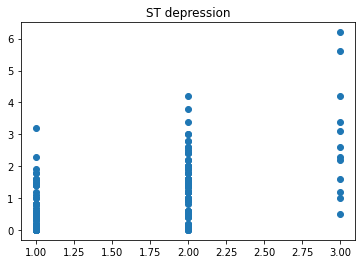

In [64]:
plt.scatter(data.slope_of_peak_exercise_st_segment, data.oldpeak_eq_st_depression)
plt.title("ST depression")
plt.show()

Build the training data and split it into test and training sets. Again I make use of the fact that the order of patient_id is the same in both files. If that was not the case I would have to sort both files in the same way before splitting.

In [65]:
X_train, X_test, y_train, y_test = train_test_split(training_data, 
                                                    labels.drop(columns=["patient_id"]), 
                                                    test_size=0.15, 
                                                    random_state=0)
            
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

First a benchmark model below for comparison with other approaches and models later on. Gradient Boosting is usually a strong model that is built up of a number of small decision trees that are called in sequence so that each call corrects the previous error. Because it is a strong model I decided to use that for the benchmark. The drawback is that this model is prone to overfitting on noisy data. The model reaches an accuracy of 74% on the test data with these parameters:

In [66]:
model_boosting = GradientBoostingClassifier(n_estimators=20, 
                                            learning_rate=2.0, 
                                            max_depth=1, 
                                            random_state=0).fit(X_train, y_train)
benchmark_score = model_boosting.score(X_test, y_test)

print("Test accuracy: " + str(benchmark_score))

Test accuracy: 0.7407407407407407


Three columns were identified as having little correlation with the presence of heart disease. This is somewhat counter-intuitive but there could be a number of explanations, such as invalid readings, an effect of the small number of records available or that these values are simply not as important as the other values in the dataset. It is also very important to note that the correlation matrix measures linear correlation. A non-linear correlation may exist even if the correlation matrix does not show it.

Before deciding whether or not to exclude the three columns, let's take a closer look at them. As mentioned a non-linear correlation may exist and since we won't be looking at linear models exclusively we need to inspect the values first.

Below two violin plots of **resting_blood_pressure**, one for those samples with no heart disease and one for samples withe heart disease present. It is a known fact that high blood pressure can lead to heart disease, it just isn.t apparent in this dataset (to me). There is not a lot of difference between the two plots. With more samples a clearer pattern might have been discernible. It could also be that there is in fact a more complex pattern of multiple correlation.

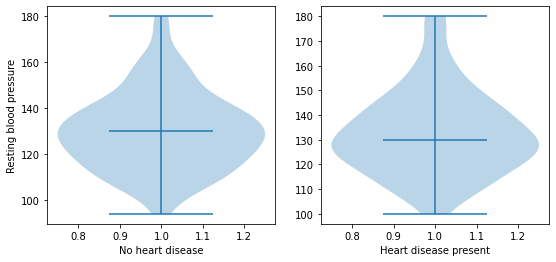

In [67]:
violin0 = data.loc[data['heart_disease_present'] == 0]
violin1 = data.loc[data['heart_disease_present'] == 1]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
axs[0].violinplot(violin0.resting_blood_pressure,
                  showmeans=False,
                  showmedians=True)
axs[0].set_xlabel('No heart disease')
axs[0].set_ylabel('Resting blood pressure')
    
axs[1].violinplot(violin1.resting_blood_pressure,
                  showmeans=False,
                  showmedians=True)
axs[1].set_xlabel('Heart disease present')
axs[0].set_ylabel('Resting blood pressure')

plt.show()

Below a bar chart of **fasting_blood_sugar_gt_120_mg_per_dl** compared to the presence or absence of heart disease. It seems the ratio between heart disease and no heart disease is more or less the same both for fasting blood suger below 120 mg/dl and above 120 mg/dl.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


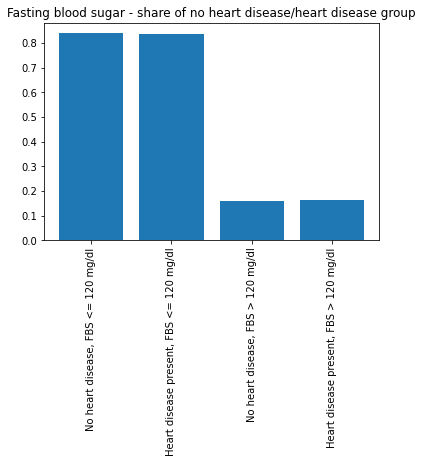

In [68]:
fig, ax = plt.subplots()
blood_sugar_counts = np.zeros((4))
blood_sugar_counts[0] = violin0.loc[violin0['fasting_blood_sugar_gt_120_mg_per_dl'] == 0]['patient_id'].count() / len(violin0)
blood_sugar_counts[1] = violin1.loc[violin1['fasting_blood_sugar_gt_120_mg_per_dl'] == 0]['patient_id'].count() / len(violin1)
blood_sugar_counts[2] = violin0.loc[violin0['fasting_blood_sugar_gt_120_mg_per_dl'] == 1]['patient_id'].count() / len(violin0)
blood_sugar_counts[3] = violin1.loc[violin1['fasting_blood_sugar_gt_120_mg_per_dl'] == 1]['patient_id'].count() / len(violin1)
ax.set_xticklabels(["No heart disease, FBS <= 120 mg/dl", "Heart disease present, FBS <= 120 mg/dl", "No heart disease, FBS > 120 mg/dl", "Heart disease present, FBS > 120 mg/dl"])
plt.xticks([1, 2, 3, 4], rotation=90)

ax.bar(np.arange(1,5),blood_sugar_counts, 0.8, align='center')
plt.title("Fasting blood sugar - share of no heart disease/heart disease group")
plt.show()

Finally, below a violin plot of presence or absence of heart disease compared to serum cholesterol levels in the first two plots. At first glance the two charts look very different but that is due to a few very high readings in the "no heart disease" category. The third plot is "No heart disease where the three samples with higher cholesterol levels than the maximum in the "heart disease present" group (353 mg/dl) have been filtered out. It is not a direct match between the last two plots, so there is information in the field that potentially could be used by a model, but with a dataset this small that would be difficult.

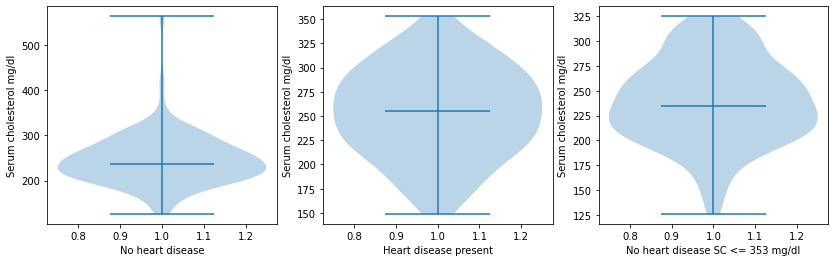

Number of samples with serum cholesterol > 353 mg/dl: 3 accounting for 1.6666666666666667% of all samples


In [69]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
axs[0].violinplot(violin0.serum_cholesterol_mg_per_dl,
                  showmeans=False,
                  showmedians=True)
axs[0].set_xlabel('No heart disease')
axs[0].set_ylabel('Serum cholesterol mg/dl')
    
axs[1].violinplot(violin1.serum_cholesterol_mg_per_dl,
                  showmeans=False,
                  showmedians=True)
axs[1].set_xlabel('Heart disease present')
axs[1].set_ylabel('Serum cholesterol mg/dl')

axs[2].violinplot(violin0.query('serum_cholesterol_mg_per_dl <= 353').serum_cholesterol_mg_per_dl,
                  showmeans=False,
                  showmedians=True)
axs[2].set_xlabel('No heart disease SC <= 353 mg/dl')
axs[2].set_ylabel('Serum cholesterol mg/dl')

plt.show()
print("Number of samples with serum cholesterol > 353 mg/dl: " + 
      str(data.query('serum_cholesterol_mg_per_dl > 353')['serum_cholesterol_mg_per_dl'].count()) +
     " accounting for " + 
      str(data.query('serum_cholesterol_mg_per_dl > 353')['serum_cholesterol_mg_per_dl'].count()/len(data)*100) +
     "% of all samples")

It seems the three fields analyzed where there is very low linear correlation with the label hold limited information that could be used by a simple model. A more complex model might be able to utilize the information in the three fields but with a total sample count of 180 avoiding overfitting would be difficult. Below a test of the same model as the benchmark model with the three fields removed from the samples in order to determine of accuracy is lower when they are left out.

In [70]:
model_boosting = GradientBoostingClassifier(n_estimators=20, 
                                            learning_rate=2.0, 
                                            max_depth=1, 
                                            random_state=0).fit(X_train.drop(columns=
                                                                             ["resting_blood_pressure", 
                                                                              "fasting_blood_sugar_gt_120_mg_per_dl", 
                                                                              "serum_cholesterol_mg_per_dl"]
                                                                            ), y_train)
fields_removed_score = model_boosting.score(X_test.drop(columns=
                                                                             ["resting_blood_pressure", 
                                                                              "fasting_blood_sugar_gt_120_mg_per_dl", 
                                                                              "serum_cholesterol_mg_per_dl"]
                                                                            ), y_test)

print("Test accuracy: " + str(fields_removed_score))

Test accuracy: 0.7407407407407407


Since the model above achieved the exact same accuracy as the benchmark model it should be ok to leave out the three fields analyzed above.

In [71]:
X_train = X_train.drop(columns=
                                                                             ["resting_blood_pressure", 
                                                                              "fasting_blood_sugar_gt_120_mg_per_dl", 
                                                                              "serum_cholesterol_mg_per_dl"]
                                                                            )
X_test = X_test.drop(columns=
                                                                             ["resting_blood_pressure", 
                                                                              "fasting_blood_sugar_gt_120_mg_per_dl", 
                                                                              "serum_cholesterol_mg_per_dl"]
                                                                            )

As mentioned previously it may be beneficial for some models to normalize the values (min-max normalization so that all values are within the span 0 to 1):

In [72]:
for column in training_data.columns:
    training_data[column] = min_max_normalize(training_data[column])
    
training_data.describe()

,slope_of_peak_exercise_st_segment,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,thal_fixed_defect,thal_normal,thal_reversible_defect
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,0.275000,0.433850,0.718519,0.231481,0.161111,0.525000,0.281304,0.162903,0.688889,0.537731,0.504560,0.316667,0.044444,0.544444,0.411111
std,0.309419,0.197796,0.312818,0.323116,0.368659,0.499371,0.120361,0.180864,0.464239,0.194474,0.208146,0.466474,0.206655,0.499410,0.493408
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.302326,0.666667,0.000000,0.000000,0.000000,0.200342,0.000000,0.000000,0.395833,0.339623,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.418605,0.666667,0.000000,0.000000,1.000000,0.272831,0.129032,1.000000,0.541667,0.528302,0.000000,0.000000,1.000000,0.000000
75%,0.500000,0.534884,1.000000,0.333333,0.000000,1.000000,0.354452,0.258065,1.000000,0.687500,0.662736,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


For later visualization of the model performance two lists are used; one for the accuracy readings and one for the names of the models:

In [73]:
scores = [] # We will use this to keep track of the best accuracy we achieve for the different models
labels = [] # ... and this for the names of the models

Below a traditional logistic regression, possibly the simplest of the models, quite fast to train, and with excellent explainability of the final model, but with some obvious drawbacks when the data cannot be fitted with a linear model. It does rather well with a test accuracy of 81%.

In [74]:
model_linear = LogisticRegression(max_iter=50).fit(X_train, y_train)
linear_score = model_linear.score(X_test, y_test)
scores += [linear_score]
labels += ["linear model"]
print("Test accuracy: " + str(linear_score))

Test accuracy: 0.8148148148148148


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Below a gridsearch to search for a random forest classifier with optimal values. Random forest is usually a strong performer where the model is made out of a number of small decision trees that are used independently. the model is faster to train than gradient boosting models and less prone to overfitting. Our search yields a result of just over 81%, the same as logistic regression.

In [75]:
parameters = {'min_samples_split':[2,8,14], 'min_samples_leaf':[1,2,3], 'max_depth':[2,3,4,5,6,7,8]}
forest = RandomForestClassifier(random_state=0)
clf = GridSearchCV(forest, parameters)
clf.fit(X_train, y_train)
print("Best Random Forest Classifier score: " + str(clf.best_score_))
print("Best Random Forest Classifier parameters: " + str(clf.best_params_))
forest_score = clf.best_estimator_.score(X_test, y_test)
scores += [forest_score]
labels += ["Random forest classifier"]
print("Test accuracy: " + str(forest_score))

Best Random Forest Classifier score: 0.8238709677419355
Best Random Forest Classifier parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 8}
Test accuracy: 0.8148148148148148


Below a gridsearch for best support vector classifier. Normally a support vector classifier is chosen if there are a large amount of fields to train on, where some other models struggle. Here we have only a few attributes so a SVC is probably not the best choice, but it still reaches an accuracy of almost 89% which is very good.

In [76]:
parameters = {'kernel':('linear', 'rbf'), 'C':np.arange(0.02, 1, 0.02)}
svc = SVC(random_state=0)
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)
print("Best Support Vector Classifier score: " + str(clf.best_score_))
print("Best Support Vector Classifier parameters: " + str(clf.best_params_))
svc_score = clf.best_estimator_.score(X_test, y_test)
scores += [svc_score]
labels += ["Support vector classifier"]
print("Test accuracy: " + str(svc_score))

Best Support Vector Classifier score: 0.8759139784946235
Best Support Vector Classifier parameters: {'C': 0.04, 'kernel': 'linear'}
Test accuracy: 0.8888888888888888


Doing a grid search for optimal parameters for a KNN classifier below does not yield a great result if we select a low value for K (n_neighbors) due to overfitting. If we choose a high K we get a much better result. Some advantages of KNN classifiers are that their are simple, not very memory intensive and do not take any time to train. They tend to struggle when the amount of data is high however (which is the case here however) and sometimes with overfitting as well (as do most other models).

In [77]:
parameters = {'n_neighbors':[30], 'p':[1,2], 'leaf_size':[1,3,5,7,9,11,13]}
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters)
clf.fit(X_train, y_train)
print("Best K Nearest Neighbors score: " + str(clf.best_score_))
print("Best K Nearest Neighbors parameters: " + str(clf.best_params_))
knn_score = clf.best_estimator_.score(X_test, y_test)
scores += [knn_score]
labels += ["KNN classifier"]
print("Test accuracy: " + str(knn_score))

Best K Nearest Neighbors score: 0.6922580645161289
Best K Nearest Neighbors parameters: {'leaf_size': 1, 'n_neighbors': 30, 'p': 1}
Test accuracy: 0.8518518518518519


Below a grid search to find the best parameters for a gradient boosting classifier. As mentioned before this is usually an excellent model with strong performance if the training data is not too noise, but slow to train which can be a challenge with gridsearch or similar methods to find optimal parameters if the training dataset is large. This model has the highest accuracy on the test data of all the models with almost 92.6% accuracy or 25 out of the 27 test samples correctly identified.

In [78]:
parameters = {'n_estimators':[1,5,10,50,100], 
              'learning_rate':[0.5,1,2,3], 
              'max_depth':[1,3,5], 
              'loss':('deviance', 'exponential'),
              'min_samples_split':[2,4,6]}

boosting = GradientBoostingClassifier(random_state=0)
clf = GridSearchCV(boosting, parameters)
clf.fit(X_train, y_train)
print("Best Gradient Boosting Classifier score: " + str(clf.best_score_))
print("Best Gradient Boosting Classifier parameters: " + str(clf.best_params_))
boosting_score = clf.best_estimator_.score(X_test, y_test)
scores += [boosting_score]
labels += ["Gradient boosting classifier"]
print("Test accuracy: " + str(boosting_score))

Best Gradient Boosting Classifier score: 0.8174193548387096
Best Gradient Boosting Classifier parameters: {'learning_rate': 1, 'loss': 'deviance', 'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 10}
Test accuracy: 0.9259259259259259


Since it is entirely possible that we are just lucky with the high accuracy on the 27 test samples we may want a few other tests on the best hyper parameters found. First K-fold training where the data set is split up K times (K=3 in the code below) in 120 train samples and 60 test samples to see how successful the model is when trained on these other splits. The second test is cross validation where the best model found during the last grid search is evaluated with subsamples of the test set to see the variation from one split to another. Ideally the mean accuracy should still be high and the deviance low. 
Mean cross validation score is approximately 79% which is not too bad, but the deviance is high.

In [79]:
X_train_and_test = np.concatenate((X_train, X_test))
y_train_and_test = np.concatenate((y_train, y_test))

kfold_accuracies = np.zeros(3)

kfold_model = GradientBoostingClassifier(learning_rate=1, 
                                         loss='deviance', 
                                         max_depth=1, 
                                         min_samples_split=2, 
                                         n_estimators=10, 
                                         random_state=0)

kf = KFold(n_splits=3)
i = 0
for train_index, test_index in kf.split(X_train_and_test):
    kfold_model.fit(X_train_and_test[train_index], y_train_and_test[train_index])
    kfold_accuracies[i] = kfold_model.score(X_train_and_test[test_index], y_train_and_test[test_index])
    i += 1
    
print('Kfold validation score ' + str(kfold_accuracies.mean()))
print('Kfold standard deviation ' + str(kfold_accuracies.std()))

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
accuracies = cross_val_score(clf.best_estimator_, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean cross validation score ' + str(accuracies.mean()))
print('Cross validation standard deviation ' + str(accuracies.std()))

Kfold validation score 0.7777777777777778
Kfold standard deviation 0.039283710065919325
Mean cross validation score 0.7283950617283951
Cross validation standard deviation 0.13967541356771307


Finally, for good measure, let us try with a densely connected neural network in Keras/Tensorflow. This is the simplest form of neural networks where all nodes are interconnected from one layer to the next but surprisingly effective although somewhat prone to overfitting so I am using an extremely small network with just 441 trainable parameters and a large dropout between the layers. After training for 15 epochs we get a good accuracy (actually less than 15 epochs are ok as well). Below 10 different networks are trained and the best performer is picked since random initialization is key in these models.

In [80]:
def define_model():
    dense = tf.keras.models.Sequential()
    dense.add(tf.keras.layers.Input(shape=12))
    dense.add(tf.keras.layers.Dense(20,activation='relu'))
    dense.add(tf.keras.layers.Dropout(0.25))
    dense.add(tf.keras.layers.Dense(10,activation='relu'))
    dense.add(tf.keras.layers.Dropout(0.15))
    dense.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    dense.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                        metrics='accuracy', 
                        optimizer=tf.keras.optimizers.SGD(learning_rate=0.00005))
    return dense

best_score = 0
best_score = 0

for i in range(0, 10):
    dense_model = define_model()
#    dense_model.summary()
    dense_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, verbose=False)
    dense_score = dense_model.evaluate(X_test, y_test, verbose=False)[1]
    if dense_score > best_score:
        best_score = dense_score
        best_dense = dense_model

dense_score = best_score
scores += [dense_score]
labels += ["Neural network"]
print("Test accuracy: " + str(dense_score))

Test accuracy: 0.8148148059844971


Below a visualization of the best accuracies achieved on the test data by the different models.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


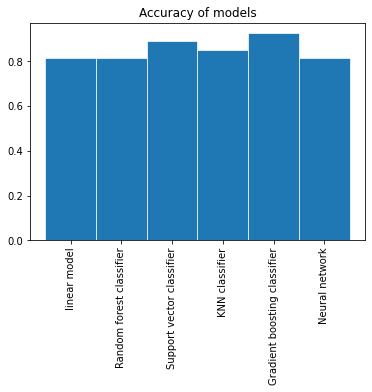

In [81]:
fig, ax = plt.subplots()
ax.bar(np.arange(1,len(scores)+1,1), scores, width=1, edgecolor="white", linewidth=0.7)
ax.set_xticklabels(["0"] + labels)
plt.xticks(rotation=90)
plt.title("Accuracy of models")
plt.show()

All models seem to do very well on this data (although the small number of samples in the data set means that there is a lot of uncertainty about how well the models would work on unknown data). 

Gradient Boosting doing best on the test data with an accuracy of almost 93% with the rest of the models being around 80% accurate on the test data.

On most training runs the neural network used does not achieve remarkable accuracy but that is probably more down to the specific model and hyper parameters specified here rather than shortcomings in neural networks in general for this kind of data.

Hyper parameter tuning as well as improvements to the architecture of the neural network could probably lead to an improvement in accuracy of most of the models but a larger dataset is definitely where the biggest improvement possibility lies. The dataset size of 180 samples are causing the models to easily overfit and the results to be less dependable than I would have liked.

So in conclusion, judging from the dataset present it is entirely possible to create a model that accurately predicts the presence of heart disease.